# [EXPLORATION-04] Making a great lyricist.

# 1. 데이터 읽어오기
* 여러 가사들에 대한 데이터는 lyrics 파일내에 저장되어 있으므로 파일을 읽어서 가사 데이터를 불러오자.

* glob 모듈을 사용하면 파일을 읽어오는 작업을 하기가 아주 용이하다.
glob 를 활용하여 모든 txt 파일을 읽어온 후, raw_corpus 리스트에 문장 단위로 저장한다.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 노래 가사 개수 및 문장 총 개수 확인

In [ ]:
import glob
import os
import re 
import numpy as np
import tensorflow as tf
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

txt_file_path = '/content/drive/MyDrive/aiffel/lyrics/*'

txt_list = glob.glob(txt_file_path)

raw_corpus = []

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("노래 가사 총 개수:", len(txt_list))
print("문장 총 개수:", len(raw_corpus))
print("Examples:\n", raw_corpus[:5])

노래 가사 총 개수: 49
문장 총 개수: 187088
Examples:
 ['Looking for some education', 'Made my way into the night', 'All that bullshit conversation', "Baby, can't you read the signs? I won't bore you with the details, baby", "I don't even wanna waste your time"]


# 2. 데이터 정제
### __원하는 데이터만 추출하기__
* 49개의 노래가사 데이터에서 필요한 문장은 각각의 가사 부분이다. 그러므로 다음과 같이 불필요한 부분은 제거해준다.
* 아래는 제거를 위한 기준이다.


### 1. __가사와 가사간의 공백인 문장__

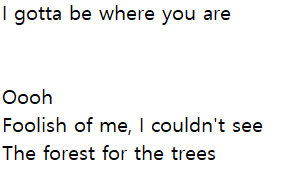


### 2. __가사가 중복되는 문장__


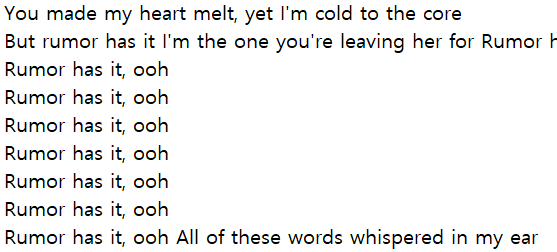


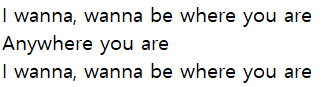


### 3. __가사의 x절이 포함된부분, 가수의 파트를 위해 포함된 부분__
* 가사의 1절, 2절을 구분하기위해 대괄호가 존재. 이는 불필요한 요소라 생각하기 때문에 제거.
* 가수들의 파트를 나누는 부분 및 chorus, 호응유도 등을 구분하기위해 대괄호가 존재. 마찬가지로 불필요한 요소.

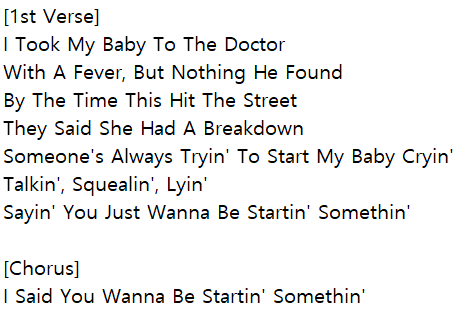


* 위의 작업을 진행시 corpus 리스트를 만들어서 각 문장마다 정제후 리스트에 바로 담는다.
* 또한 리스트에 공백, 대괄호가 포함된 문장이 제외되었을 것 이지만 중복된 문장이 존재할 것 이므로 세트(set)의 중복불가 특성을 이용하여 정제해준다.

In [ ]:
corpus = [] # 미리 정제된 문장들을 담을 corpus

for idx, sentence in enumerate(raw_corpus):
    if len(sentence) == 0: continue         # 길이가 0인 문장은 건너뛰기.
    if ('[' and ']') in sentence: continue  # 대괄호가 들어가는 문장 제외.
    if sentence[-1] == ":": continue        # 문장의 끝이 : 인 문장은 건너뛰기.

    corpus.append(sentence)

print(f"raw_corpus의 문장 총 개수 : ", len(raw_corpus))
print(f'공백인 문장, 대괄호 들어간 문장 삭제한 데이터 개수 : {len(corpus)}')

corpus = list(set(corpus))    # 중복불가한 set의 특성을 이용. 중복제거후 다시 corpus리스트로 변환.
print(f'중복문장 제외한 문장 총 크기 : {len(corpus)}')

raw_corpus의 문장 총 개수 :  187088
공백인 문장, 대괄호 들어간 문장 삭제한 데이터 개수 : 174209
중복문장 제외한 문장 총 크기 : 116907


### preprocess_sentence(sentence):
* 이 함수의 목적은 문장을 기준에 따라 정제하여 토큰화(Tokenize)해준다.
* 전처리를 위해 정규표현식(Regex)을 이용한 필터링 사용
  * 입력된 문장을 소문자로 바꾸고, 양쪽 공백을 지웁니다
  * 특수문자 양쪽에 공백을 넣고
  * 여러개의 공백은 하나의 공백으로 바꿉니다
  * a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꿉니다
  * 다시 양쪽 공백을 지웁니다
  * 문장 시작에는 `<start>`, 끝에는 `<end>`를 추가합니다

In [ ]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 소문자로 바꾸고, 양쪽 공백을 지웁니다
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 특수문자 양쪽에 공백을 넣고
    sentence = re.sub(r'[" "]+', " ", sentence) # 여러개의 공백은 하나의 공백으로 바꿉니다
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꿉니다
    sentence = sentence.strip() # 다시 양쪽 공백을 지웁니다
    sentence = '<start> ' + sentence + ' <end>' # 문장 시작에는 <start>, 끝에는 <end>를 추가합니다
    
    return sentence

In [ ]:
corpus_tokenized = []

for sentence in corpus:
    # 토큰화(전처리) 함수 호출
    preprocessed_sentence = preprocess_sentence(sentence)
    corpus_tokenized.append(preprocessed_sentence)
        
print("문장 총 개수:", len(corpus_tokenized))

# random으로 문장 확인
random.sample(corpus_tokenized, 20)

문장 총 개수: 116907


['<start> you a little smaller <end>',
 '<start> and it cut me like a knife <end>',
 '<start> black nasty and mad fat yall <end>',
 '<start> i could have touched ! <end>',
 '<start> i m drownin in the poison , got no future , got no past <end>',
 '<start> turn around <end>',
 '<start> a fear will urge it where <end>',
 '<start> when i left my home the sky split open wide <end>',
 '<start> look , i did not sign up for this <end>',
 '<start> i got checks gained a lot of respect now everywhere i go they holla my name luda ! <end>',
 '<start> and i thought i was gonna jump with joy <end>',
 '<start> maurice , what , what can i serve u ? umean he s male ? <end>',
 '<start> i done talked a lot of shit but i just did the numbers <end>',
 '<start> faces fill with madness <end>',
 '<start> cause i m only and i m only gettin better <end>',
 '<start> you know that i m living <end>',
 '<start> i m feeling on yo booty feelin on yo booty , <end>',
 '<start> trapping ain t dead , getting money like t

# 3. 토큰화 및 벡터화
* `tf.keras.preprocessing.text.Tokenizer` 패키지는 정제된 데이터를 토큰화하고, 단어 사전(vocabulary 또는 dictionary라고 칭함)을 만들어주며, 데이터를 숫자로 변환까지 한 방에 해줌.
* 이 과정을 벡터화(vectorize) 라 하며, 숫자로 변환된 데이터를 텐서(tensor) 라고 함.
* 12000 단어를 기억할 수 있는 tokenizer 생성

In [ ]:
# 토큰화 할 때 텐서플로우의 Tokenizer와 pad_sequences를 사용합니다
def tokenize(corpus):
    # 12000단어를 기억할 수 있는 tokenizer를 생성
    # 이미 문장을 정제했으니 filters가 필요없음
    # 12000단어에 포함되지 못한 단어는 '<unk>'로 변경
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=12000, 
        filters=' ',
        oov_token="<unk>"
    )
    # corpus를 이용해 tokenizer 내부의 단어장을 완성합니다
    tokenizer.fit_on_texts(corpus)

    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환합니다
    tensor = tokenizer.texts_to_sequences(corpus)   

    # 입력 데이터의 시퀀스 길이를 일정하게 맞춰줍니다
    # 만약 시퀀스가 짧다면 문장 뒤에 패딩을 붙여 길이를 맞춰줍니다.
    # 문장 앞에 패딩을 붙여 길이를 맞추고 싶다면 padding='pre'를 사용합니다
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')  
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus_tokenized)

[[   2    9 2587 ...    0    0    0]
 [   2    5   21 ...    0    0    0]
 [   2   85  163 ...    0    0    0]
 ...
 [   2  175   18 ...    0    0    0]
 [   2   31   50 ...    0    0    0]
 [   2    1   28 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7f991a912810>


### 텐서의 길이 및 토큰 확인
* 첫번째 토큰을 확인하니 짧은 문장이 나왔다.
* 하지만 tensor의 길이를 확인하니 347이 나왔다.
* 대부분의 문장에 0이 추가됨.

In [ ]:
print(f'tensor의 shape : {tensor.shape}')
print(f'첫번째 tensor\n : {tensor[0]}')
print(f'첫번째 token : {corpus_tokenized[0]}')
print(f'첫번째 token의 길이 : {len(corpus_tokenized[0])}')

tensor의 shape : (116907, 347)
첫번째 tensor
 : [   2    9 2587   44   70   73    4    9 2587   44   70  123   13  838
   26   13 1796    3    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0   

### 각 문장 길이에 대한 distribution check

* 각 텐서에 대해 0이 아닌 개수들을 구하여 시각화 해본다.
* 기본적인 boxplot과 histogram을 출력해본다.

In [ ]:
tensor_len_list = []

for tensor_check in tensor:
    count = 0
    for tensor_count in tensor_check:
        if tensor_count != 0:
            count += 1
    
    tensor_len_list.append(count)

<function matplotlib.pyplot.show>

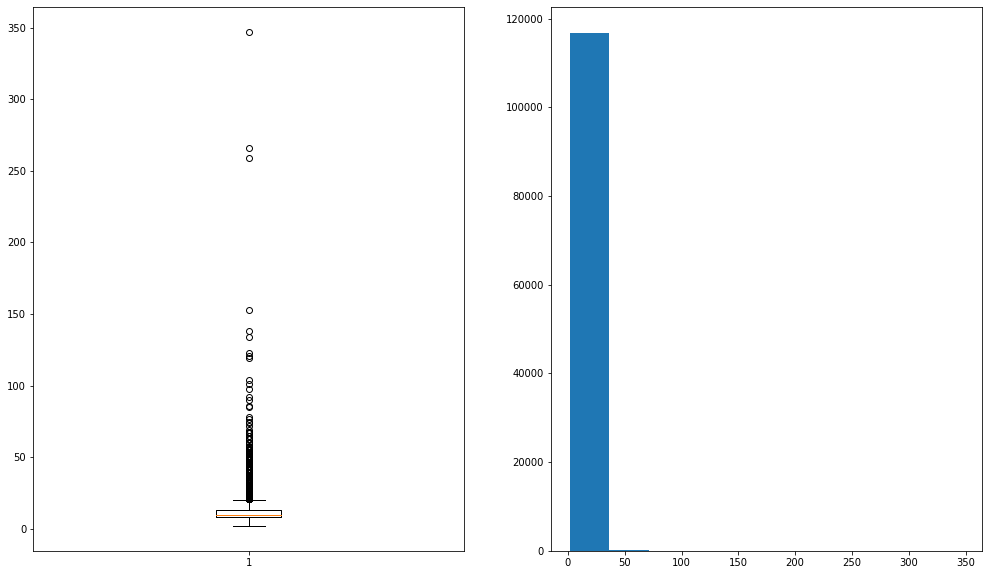

In [ ]:
plt.figure(figsize=(17,10))
plt.subplot(1,2,1)
plt.boxplot(tensor_len_list)
plt.subplot(1,2,2)
plt.hist(tensor_len_list)
plt.show

위의 boxplot을 보면 분명히 0~100사이 밀집되어 있다. 하지만 이대로는 제대로 확인이 불가하다.

### 각 문장의 길이가 어떤 분포로 구성되어 있는지 시각화 한다.
* 각각의 문장에 대해 길이와 그 길이에 해당하는 개수를 구하여 딕셔너리화 한다.

<function matplotlib.pyplot.show>

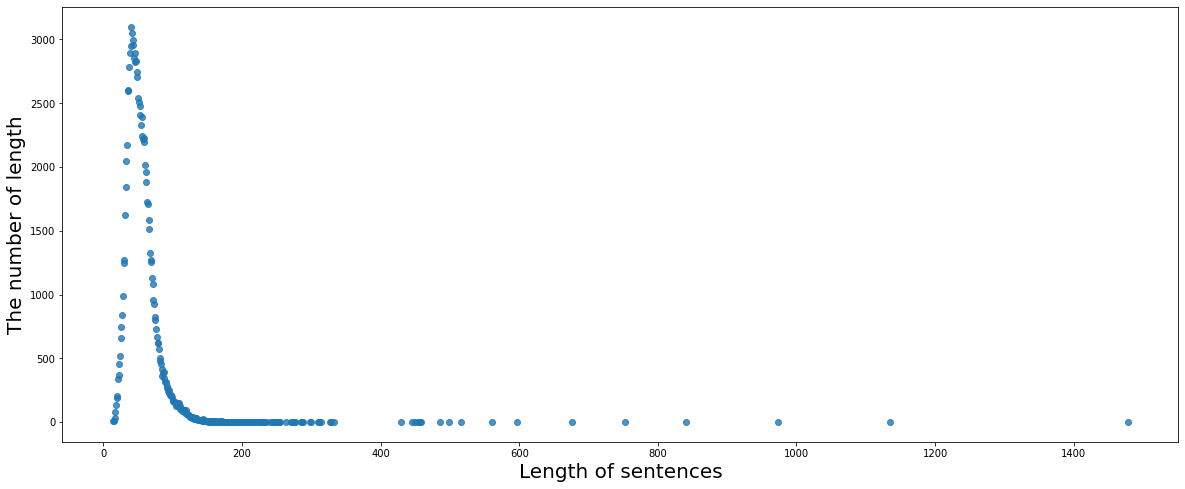

In [ ]:
len_dict = {}

for cor in corpus_tokenized:
    if len(cor) in len_dict:
        len_dict[len(cor)] += 1
    else:
        len_dict[len(cor)] = 1        
        
# scatter plot
plt.figure(figsize=(20, 8))
plt.xlabel('Length of sentences', fontsize=20)
plt.ylabel('The number of length', fontsize=20)
plt.scatter(len_dict.keys(), len_dict.values(), alpha=0.8)
plt.show

### scatter plot으로 출력시 분포의 형태가 0에서 약 30사이 집중 포진되어있다.
* 문장의 길이가 다른 문장에 비해 길기 때문에 행 뒤에 0으로 패딩(padding)이 **비정상적**으로 이루어짐
* 일반적으로 이상치의 기준은 다르지만 현재의 상황에서 볼 때 비정상적으로 긴 문장은 **모델의 성능에 다소 악영향**을 끼칠 것 같다.
* 그러므로 일정 길이 이상의 문장의 개수를 확인해 본다.

In [ ]:
corpus_tokenized[0]

'<start> a kingston they come from , a kingston they come through my mom is my hero <end>'

In [ ]:
# 문장의 길이가 긴 것들을 직접 출력해서 실체를 확인해보자
# 미리 확인한 결과 길이가 200이 넘는 문장은 80개, 150이 넘는 문장은 총 228개가 있다
count = 0
count_100 = 0
count_150 = 0
count_200 = 0
count_250 = 0
dummy = []

for outlier_corpus in corpus_tokenized:
    if len(outlier_corpus) < 100:
        count +=1
    
    if len(outlier_corpus) >= 100:
        count_100 +=1
    
    if len(outlier_corpus) >= 150:
        count_150 +=1
    
    if len(outlier_corpus) >= 200:
        count_200 +=1
    
    if len(outlier_corpus) >= 250:
        count_250 +=1

print("문장의 길이가 100 미만인 sentence의 개수:", count)
print("문장의 길이가 100 이상인 sentence의 개수:", count_100)
print("문장의 길이가 150 이상인 sentence의 개수:", count_150)
print("문장의 길이가 200 이상인 sentence의 개수:", count_200)
print("문장의 길이가 250 이상인 sentence의 개수:", count_250)

for index, outlier_corpus in enumerate(corpus_tokenized):
    if len(outlier_corpus) >= 250:
        print(outlier_corpus)
    
    if index == 20000 :
        break

문장의 길이가 100 미만인 sentence의 개수: 113337
문장의 길이가 100 이상인 sentence의 개수: 3570
문장의 길이가 150 이상인 sentence의 개수: 237
문장의 길이가 200 이상인 sentence의 개수: 80
문장의 길이가 250 이상인 sentence의 개수: 40
<start> to what further rigorous pruning her verses would have been subjected had she published them herself , we cannot know . they should be regarded in many cases as merely the first strong and suggestive sketches of an artist , intended to be embodied at some time in the finished picture . <end>
<start> she had tried society and the world , and found them lacking . she was not an invalid , and she lived in seclusion from no love disappointment . her life was the normal blossoming of a nature introspective to a high degree , whose best thought could not exist in pretence . <end>
<start> the eagerness with which the first volume of emily dickinson s poems has been read shows very clearly that all our alleged modern artificiality does not prevent a prompt appreciation of the qualities of directness and simplicity in

### 문장의 길이 확인 결과
* 문장의 길이가 **100 미만**인 sentence의 개수: **113337**
* 문장의 길이가 **100 이상**인 sentence의 개수: **3570**
* 문장의 길이가 **150 이상**인 sentence의 개수: **237**
* 문장의 길이가 **200 이상**인 sentence의 개수: **80**
* 문장의 길이가 **250 이상**인 sentence의 개수: **40**

## 실제 문장의 길이가 100미만 개수의 비율은 **96.65%** 이고,문장의 길이가 150미만인 개수의 비율은 **99.7%** 이므로 확률분포측면에서 보았을때 분포의 설명력이 좋다.

## 나머지 150이상의 문장들은 불필요하다 라고는 말 할수 없지만 모델의 입장에서는 그지 좋은선택은 아닌 것 같으므로, **문장의 길이가 150 이상인 문장들은 제거**한다.

* 이후 제거된 문장으로 다시 토큰화를 진행.

In [ ]:
# 문장 길이가 150 이상인 문장들은 제거

final_corpus_tokenized = []
count = 0

for cor in corpus_tokenized:
    if len(cor) < 150:
        final_corpus_tokenized.append(cor)
    else:
        count += 1
        
print("삭제한 문장 개수: ", count)
print("최종 문장 개수:", len(final_corpus_tokenized))

삭제한 문장 개수:  237
최종 문장 개수: 116670


In [ ]:
# final_corpus_tokenized를 이용해 재(re) 토큰화
tensor, tokenizer = tokenize(final_corpus_tokenized)

print(f'tensor의 shape : {tensor.shape}')
print(f'첫번째 tensor\n : {tensor[0]}')
print(f'첫번째 token : {corpus_tokenized[0]}')
print(f'첫번째 token의 길이 : {len(corpus_tokenized[0])}')

[[   2    9 2562 ...    0    0    0]
 [   2    5   21 ...    0    0    0]
 [   2   85  162 ...    0    0    0]
 ...
 [   2  173   18 ...    0    0    0]
 [   2   31   50 ...    0    0    0]
 [   2    1   28 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7f99198f6c50>
tensor의 shape : (116670, 39)
첫번째 tensor
 : [   2    9 2562   44   70   73    4    9 2562   44   70  124   13  834
   26   13 1786    3    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0]
첫번째 token : <start> a kingston they come from , a kingston they come through my mom is my hero <end>
첫번째 token의 길이 : 88


# 4. 텐서를 source 와 target 분리
* 생성된 텐서를 소스와 타겟으로 분리하여 모델이 학습할 수 있게 진행

* 텐서 출력부에서 행 뒤쪽에 0이 많이 나온 부분은 정해진 입력 시퀀스 길이보다 문장이 짧을 경우 0으로 패딩(padding)을 채워 넣은 것. 사전에는 없지만 0은 바로 패딩 문자 `<pad>`가 될 것.

In [ ]:
# tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성합니다
# 마지막 토큰은 <end>가 아니라 <pad>일 가능성이 높습니다.
src_input = tensor[:, :-1]

# tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.
tgt_input = tensor[:, 1:]    

print(src_input[0])
print(tgt_input[0])

[   2    9 2562   44   70   73    4    9 2562   44   70  124   13  834
   26   13 1786    3    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
[   9 2562   44   70   73    4    9 2562   44   70  124   13  834   26
   13 1786    3    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]


# 5. 데이터셋 객체를 생성
* tf.data.Dataset객체를 생성하는 방법 사용
* `tf.data.Dataset.from_tensor_slices()` 메소드를 이용해 tf.data.Dataset객체를 생성.

In [ ]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

 # tokenizer가 구축한 단어사전 내 12000개와, 여기 포함되지 않은 0:<pad>를 포함하여 12001개
VOCAB_SIZE = tokenizer.num_words + 1   

# 준비한 데이터 소스로부터 데이터셋을 만듭니다
dataset = tf.data.Dataset.from_tensor_slices((src_input, tgt_input))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset shapes: ((256, 38), (256, 38)), types: (tf.int32, tf.int32)>

# 6. 모델 구성

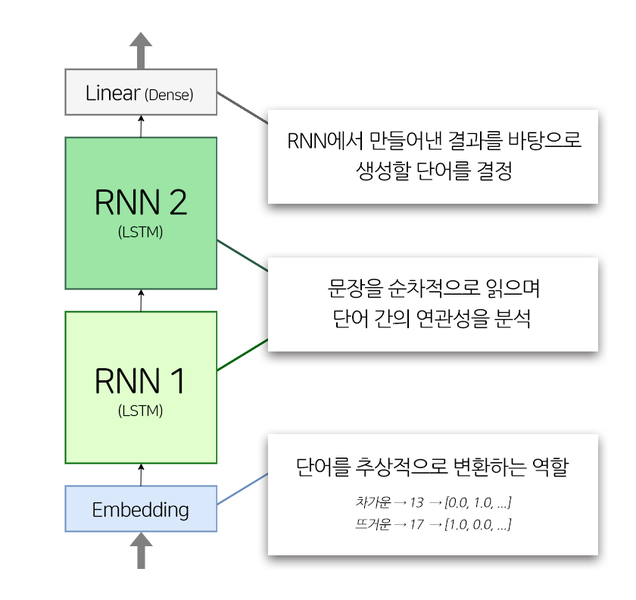

In [ ]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 256
hidden_size = 1024
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

# 7. Validation 데이터셋 분리
전체 중 20%를 validation을 위해 분리

In [ ]:
# 전체 중 20%를 validation을 위한 데이터셋으로 분리
src_train, src_val, tgt_train, tgt_val = train_test_split(
    src_input, tgt_input,
    test_size=0.2,
    random_state=35
)

# 각 데이터셋 사이즈 확인
print("Source train: ", src_train.shape)
print("Target train: ", tgt_train.shape)
print("Source validation: ", src_val.shape)
print("Target validation: ", tgt_val.shape)

Source train:  (93336, 38)
Target train:  (93336, 38)
Source validation:  (23334, 38)
Target validation:  (23334, 38)


# 8. 모델 학습

In [ ]:
# optimizer와 loss등은 차차 배웁니다 
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

model.compile(loss=loss, optimizer=optimizer)
History = model.fit(src_train, tgt_train, validation_data=(src_val, tgt_val), batch_size=BATCH_SIZE, epochs=10)

Epoch 1/10
365/365 [==============================] - 186s 490ms/step - loss: 1.7007 - val_loss: 1.4212
Epoch 2/10
365/365 [==============================] - 176s 483ms/step - loss: 1.3726 - val_loss: 1.3438
Epoch 3/10
365/365 [==============================] - 182s 497ms/step - loss: 1.3064 - val_loss: 1.2992
Epoch 4/10
365/365 [==============================] - 181s 497ms/step - loss: 1.2619 - val_loss: 1.2725
Epoch 5/10
365/365 [==============================] - 181s 497ms/step - loss: 1.2273 - val_loss: 1.2547
Epoch 6/10
365/365 [==============================] - 182s 497ms/step - loss: 1.1972 - val_loss: 1.2398
Epoch 7/10
365/365 [==============================] - 176s 483ms/step - loss: 1.1696 - val_loss: 1.2292
Epoch 8/10
365/365 [==============================] - 182s 498ms/step - loss: 1.1434 - val_loss: 1.2200
Epoch 9/10
365/365 [==============================] - 182s 498ms/step - loss: 1.1183 - val_loss: 1.2137
Epoch 10/10
365/365 [==============================] - 176s 483m

# 9. 모델평가

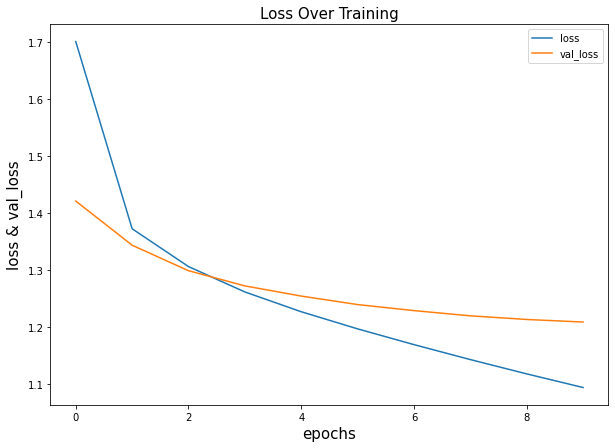

In [ ]:
fig = plt.figure(figsize=(10, 7))

plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])

plt.title('Loss Over Training', fontsize=15)
plt.xlabel('epochs', fontsize=15)
plt.ylabel('loss & val_loss', fontsize=15)
plt.legend(['loss','val_loss'])

plt.show()

# 10. 잘 만들어졌는지 평가하기

In [ ]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다
    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

In [ ]:
generate_text(model, tokenizer, init_sentence="<start> why")

'<start> why you want me to be <end> '

In [ ]:
generate_text(model, tokenizer, init_sentence="<start> you")

'<start> you re the only one that i m gonna be <end> '

In [ ]:
generate_text(model, tokenizer, init_sentence="<start> baby")

'<start> baby , i m gonna be the one <end> '

In [ ]:
generate_text(model, tokenizer, init_sentence="<start> green")

'<start> green eggs and ham <end> '

In [ ]:
generate_text(model, tokenizer, init_sentence="<start> two")

'<start> two years , i m not a <unk> <end> '

In [ ]:
generate_text(model, tokenizer, init_sentence="<start> do")

'<start> do you wanna do it <end> '

In [ ]:
generate_text(model, tokenizer, init_sentence="<start> what")

'<start> what you want to do <end> '

In [ ]:
generate_text(model, tokenizer, init_sentence="<start> don")

'<start> don t you know that i m gonna be <end> '

In [ ]:
generate_text(model, tokenizer, init_sentence="<start> i really")

'<start> i really wanna be the one <end> '

In [ ]:
generate_text(model, tokenizer, init_sentence="<start> how")

'<start> how many times i ve been <end> '

In [ ]:
generate_text(model, tokenizer, init_sentence="<start> i love")

'<start> i love you , i m not gonna be <end> '

In [ ]:
generate_text(model, tokenizer, init_sentence="<start> ")

'<start> holly say i m a <unk> <end> '

# 11. 결론 및 추가생각
* 가사와 가사간의 공백인 문장
* 가사가 중복되는 문장
* 가사의 x절이 포함된부분, 가수의 파트를 위해 포함된 부분
* 입력된 문장을 소문자로 바꾸고, 특수문자 양쪽에 공백을 넣고
* 여러개의 공백은 하나의 공백으로 바꾸고
* a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꾸고
* 양쪽 공백을 지우고, 문장 시작에는 `<start>`, 끝에는 `<end>`를 추가

### 또한 다음과 같은 과정을 거쳤다.

* 처음 문장의 텐서가 비정상적으로 길어짐을 확인했다.
* 실제 문장의 길이가 150미만인 개수의 비율은 99.7% 이므로 확률분포측면에서 보았을때 분포의 설명력이 좋다.
* 그러므로 나머지 150이상의 문장들은 불필요하다 라고는 말 할수 없지만 모델의 입장에서는 그지 좋은선택은 아닌 것 같으므로, 문장의 길이가 150 이상인 문장들은 제거하여 모델을 생성하고 검증데이터를 통해 검증하였다.

### 성능에 대하여
처음부터 다소 낮은 loss값이 검출되었다.
이것이 학습자체를 잘했는지 잘 못했는지는 구분이 되지 않는다.

### 문장에 대하여...
* 파라미터 값을 알맞게 지정하여 모델을 학습시킨결과 다소 괜찮은 문장들이 추출되었다.
* 하지만 여전히 문장 문법이 어색하거나, 내용이 어색한 문장도 종종 생성되었다.
* 또한 학습 할때마다 결과가 달라서 놀라웠다. 처음 학습시 `green`이라는 단어를 만들어 적용시 green blue red green green ... 처럼 나타났지만 다시 학습을 시켰을때는 문장이 다소 어색하지만 제대로된 문장이 나왔다.
* 일반적인 문장들도 자주 나왔다.

### 이해에 대하여
* 아직 RNN에 대하여 자세한 원리나 동작방식을 완벽하게 이해하지 못 한채 진행을 했다.
* 또한 토큰화, 말뭉치 등 다소 생소하고 처음보는 단어와, 그 단어의 개념들이 등장하여 본질을 이해하지 못 한 상태에서 실습을 진행하였다.
* NLP뿐만 아니라 딥러닝에서는 개념적 이해가 중요해 보인다. 이것에 대해 조금더 공부한 후 다시 보면 매력적일 것이라 생각한다.

#### 어이없는 문장들도 다소 나왔지만 매력적이라 생각한다. 사람의 말을 수학적으로 변환하여 문장을 생성한다는 것 자체가 의미가 있고 흥미롭다 생각한다. 다만 아까 언급했듯, 아직 생소하고 완벽한 이해가 되지 않기 때문에 다소 힘들었다 생각한다. 추후 현재의 데이터 말고 다양한 데이터를 이용하고, 개념적인 것들에대한 이해, 하이퍼 파라미터에 대한 느낌과, 통계적인 생각들이 합해지면 조금 더 nice한 모델이 생성되지 않을까 생각한다. 